# Effects of Monthly income, Loan amount and Prosper rating on Loan status and Borrower APR 
## by Adil Raheem

## Investigation Overview
In this investigation, i want to know what affects a loan's outcome status and borrower's APR. The main focus was on six variables, the are: BorrowerAPR, StatedMonthlyIncome, LoanOriginalAmount,  ProsperRating, ProsperScore and LoanStatus.


## Dataset Overview

The data contains loan listings and attributes of aprroimately 114,000 loans. The attributes include 5 numeric variables (BorrowerAPR, StatedMonthlyIncome, LoanOriginalAmount, EmploymentStatusDuration, BorrowerRate), two variables boolean variables (IsBorrowerHomeowner, IncomeVerifiable), 4 categorical variables (ProsperRating (Alpha), Prosper score, LoanStatus and EmploymentStatus).<br>
29,104 data points were removed from the dataset due to missing values in vital attributes (ProsperRating (Alpha) and Prosper score). These missing data points are quite large but they were rather removed because prosper rating and prosper scores were built using historical Prosper data to assess the risk of Prosper borrower listings. Hence, it is better off not imputing these data points because they are both attributes are categorical. This left us with arpproximately 85,000 data points to work with.<br> 
Since these prosper variables are only availabe for loan listings that originated after july 2009, this analysis is thus assumed to be focused on loans from July 2009.

In [2]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [3]:
# load in the dataset into a pandas dataframe
loan_df = pd.read_csv('ProsperLoanData.csv')

In [4]:
columns_needed = ['BorrowerAPR','BorrowerRate','StatedMonthlyIncome','LoanOriginalAmount','EmploymentStatusDuration','ProsperScore','ProsperRating (Alpha)',
                 'IsBorrowerHomeowner','IncomeVerifiable', 'LoanStatus', 'EmploymentStatus']
loan_data = loan_df[columns_needed]

In [5]:
loan_data = loan_data.dropna(subset =['EmploymentStatus','EmploymentStatusDuration','ProsperRating (Alpha)','ProsperScore'])

In [6]:
to_be_replaced = ['Past Due (1-15 days)', 'Past Due (31-60 days)','Past Due (61-90 days)',
                                          'Past Due (91-120 days)','Past Due (16-30 days)','Past Due (>120 days)' ]
loan_data.loc[loan_data['LoanStatus'].isin(to_be_replaced), 'LoanStatus'] = 'Past Due'

In [7]:
ordinal_var_dict = {'ProsperRating (Alpha)' :['AA','A','B','C','D','E','HR']}

for var in ordinal_var_dict:
    ordered_var = pd.api.types.CategoricalDtype(ordered=True, categories= ordinal_var_dict[var] )
    loan_data[var] = loan_data[var].astype(ordered_var)

In [8]:
def cat_order(x):
    return loan_data[x].value_counts().index
def base_color():
    return sns.color_palette()[0]

In [9]:
def remove_outliers (DataFrame, target_column):
    Q1 = DataFrame[target_column].quantile(0.25)
    Q3 = DataFrame[target_column].quantile(0.75)
    IQR = Q3 - Q1
    outlier_1 = Q1 - 1.5 * IQR
    outlier_2 = Q3 + 1.5 * IQR
    
    DataFrame = DataFrame.loc[((DataFrame[target_column] < outlier_1) | (DataFrame[target_column] > outlier_2 ))]
    return DataFrame

In [10]:
income_outliers = remove_outliers(loan_data, 'StatedMonthlyIncome')
income_no_outlier = loan_data[~loan_data['StatedMonthlyIncome'].isin
                                                      (income_outliers['StatedMonthlyIncome'])]

In [11]:
new_loan_df = loan_data[(loan_data['LoanStatus'] == 'Completed') | (loan_data['LoanStatus'] == 'Defaulted') | (loan_data['LoanStatus'] == 'Expired')|
(loan_data['LoanStatus'] == 'ChargedOff') | (loan_data['LoanStatus'] == 'Past Due')]

In [12]:
failed_loan = ['Defaulted','ChargedOff', 'Past Due', 'Expired']
successful = ['Completed']

new_loan_df.loc[new_loan_df['LoanStatus'].isin(failed_loan), 'LoanStatus'] = 'Failed'
new_loan_df.loc[new_loan_df['LoanStatus'].isin(successful), 'LoanStatus'] = 'Success'

In [13]:
new_loan_df.rename(columns={'LoanStatus':'LoanStatusOutcome'}, inplace =True)

> Note that the above cells have been set as "Skip"-type slides. That means
that when the notebook is rendered as http slides, those cells won't show up.

## Distribution of Stated Monthly Income

Stated monthly income consist of a very large range of values from the lowest at 0 and the highest at $1,750,00.  When plotted on a logaritmic scale, the distribution is unimodal. 

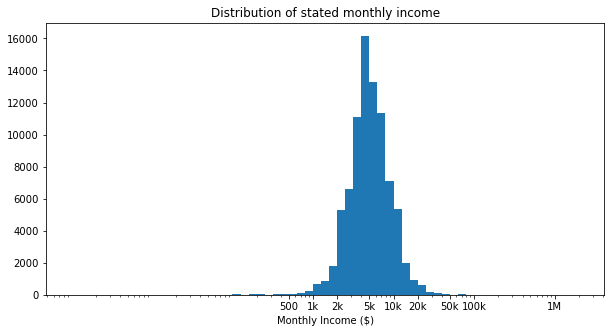

In [14]:
log_binsize = 0.1
bins = 10 ** np.arange(0, np.log10(loan_data['StatedMonthlyIncome'].max())+log_binsize, log_binsize)

plt.figure(figsize=[10, 5])
plt.hist(data = loan_data, x = 'StatedMonthlyIncome', bins = bins)
plt.xscale('log')
plt.xticks([500,1e3, 2e3, 5e3, 1e4, 2e4, 5e4, 1e5, 1e6], ['500', '1k', '2k', '5k','10k','20k','50k','100k','1M'])
plt.xlabel('Monthly Income ($)')
plt.title('Distribution of stated monthly income')
plt.show()

## Distribution of Loan Original Amount

A large proportion of loan listings had their loan original amount in multiples of 500. A loan amount of $4000 was the most frequently given amount. 

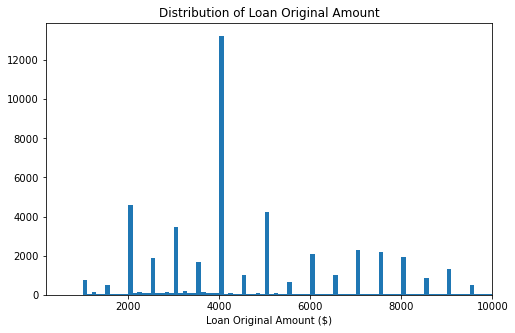

In [15]:
plt.figure(figsize=[8,5])
bins = np.arange(0, loan_data['LoanOriginalAmount'].max()+100 ,100 )
plt.hist(data= loan_data, x='LoanOriginalAmount', bins=bins)
plt.xlim([200,10000])
plt.xlabel('Loan Original Amount ($)')
plt.title('Distribution of Loan Original Amount');

## Distribution of Borrower APR

Borrower APR has a slightly right skewed distribution with its values ranging from 0.006 to 0.512

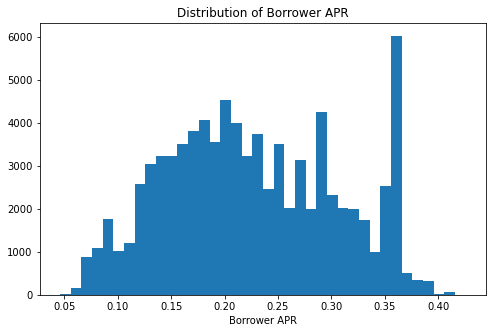

In [16]:
plt.figure(figsize = [8, 5])
bins = np.arange(min(loan_data['BorrowerAPR']), max(loan_data['BorrowerAPR']) + 0.01, 0.01)
plt.hist(data=loan_data, x='BorrowerAPR', bins=bins)
plt.xlabel('Borrower APR')
plt.title('Distribution of Borrower APR');

## Borrower APR and Loan Status
There is a strong relationship between  borrower APR and loan status. Loan status is affected by borrower APR as high borrower APR results in late payment or non-payment of loans, this indicates that failed loan outcome is caused by high interest rates. 

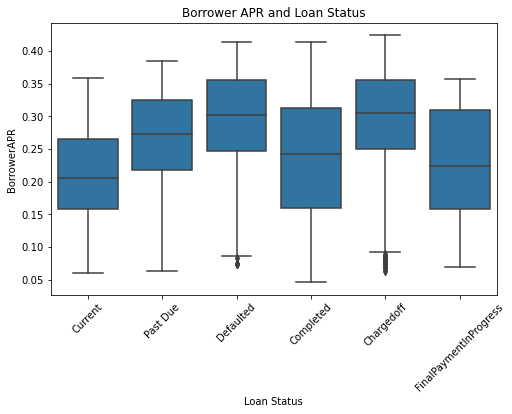

In [17]:
plt.figure(figsize = [8,5])
sns.boxplot(data=loan_data, x='LoanStatus', y='BorrowerAPR',color=base_color())
plt.title('Borrower APR and Loan Status')
plt.xlabel('Loan Status')
plt.xticks(rotation=45);

## Prosper variables and Borrower APR
As prosper rating moves from best/lowest risk (AA) to worst/high risk (HR), borrower APR increases. Also, as prosper score increases from worst/ high risk score (1) to best/ lowest risk score (11), borrower APR gradually decreases. low borrower APR is associated with low risk side of prosper ratings and prosper scores.

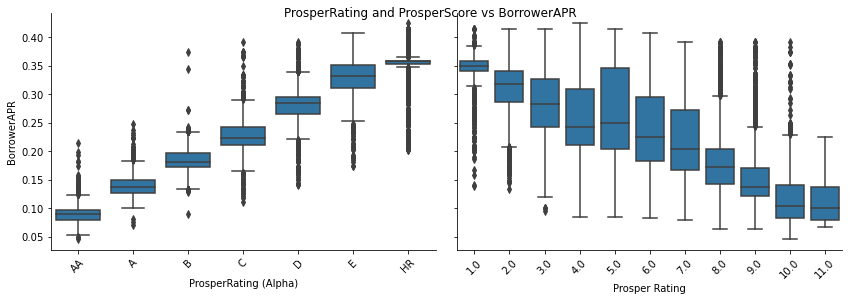

In [18]:
def boxgrid(x,y, **kwargs):
    sns.boxplot(x,y, color=base_color())

plt.rcParams["figure.figsize"] = (15,15)
g= sns.PairGrid(data=loan_data, x_vars= ['ProsperRating (Alpha)','ProsperScore'], 
                y_vars=['BorrowerAPR'] ,
                size=4, aspect =1.5)
g.map(boxgrid)
for ax in g.axes.flatten():
    # rotate x axis labels
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)


plt.suptitle('ProsperRating and ProsperScore vs BorrowerAPR ')
plt.xlabel('Prosper Rating')
plt.show();




## Loan Status and Stated Monthly Income
With stated monthly income outliers removed, an interaction effect between stated monthly income and loan status was visible. Completed loan status seems to have a slightly higher monthly income when compared with Defaulted, Past Due and Charged Off. Although these 3 statuses can be seen to have lower median monthly incomes, the difference between their median value and other loan status is less $1000. Since Defaulted, Past Due and Charged Off all account for a failed loan, simplifying the loan status category into success and failure would help provide a better analysis conclusion. This called for a further investigation on the relationship between loan status and monthly income.

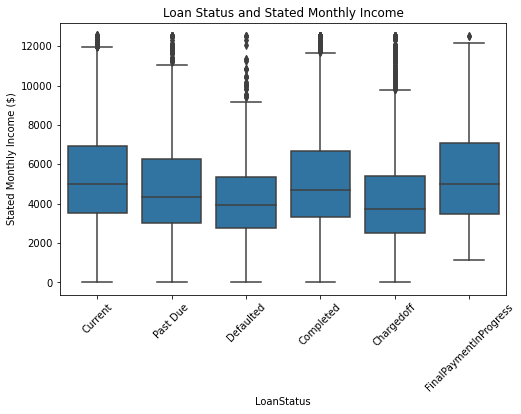

In [19]:
plt.figure(figsize = [8,5])
sns.boxplot(data = income_no_outlier, x= 'LoanStatus', y='StatedMonthlyIncome',color=base_color())
plt.title('Loan Status and Stated Monthly Income')
plt.ylabel('Stated Monthly Income ($)')
plt.xticks(rotation=45);

## Loan Status and Loan Original Amount
The interaction effect between stated monthly income and loan status was also visible after removing outliers. Apart from the loan status that indicate the loan listings in progess (i.e. current and final payment in progress), past Due loans had the highest range of loan original amount, this indicated that failure to make payments was attributed to high loan original amount.  However, completed loans which have a lower range of values when compared with past due loans seem to have approximately the same median value and close range of values as the other failed loan statuses i.e. defaulted and charged off,indicating that a high loan original amount doesn't necessarily result into failed loans status. This will however be further investigated.

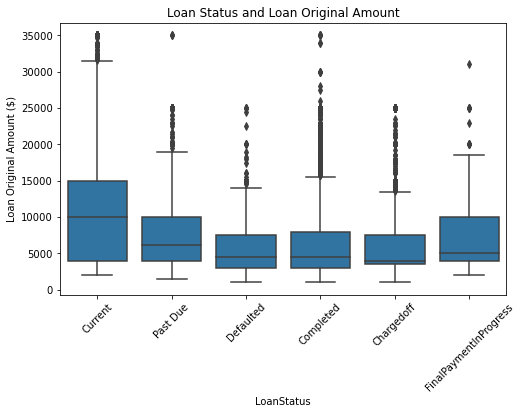

In [20]:
plt.figure(figsize = [8,5])
sns.boxplot(data = income_no_outlier, x= 'LoanStatus', y='LoanOriginalAmount',color=base_color())
plt.title('Loan Status and Loan Original Amount')
plt.ylabel('Loan Original Amount ($)')
plt.xticks(rotation=45);

## Prosper Rating and Stated Monthly Income for Loan Outcome Status
There is an effect of increased stated monthly income on prosper rating, the higher the monthly income gets, the better the listing's prosper rating. We can also see that for every rating, loan listings with higher monthly income have a loan outcome satus of success.Failed loan outcome status is seen to be associated with low stated monthly income.

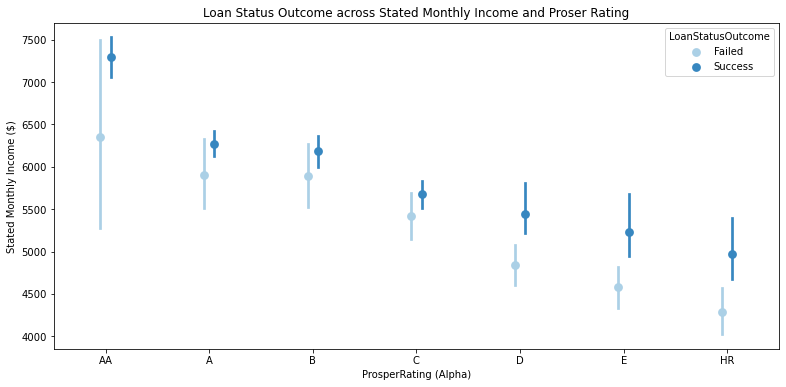

In [21]:
plt.figure(figsize = [13,6])
ax= sns.pointplot(data=new_loan_df, hue='LoanStatusOutcome', x='ProsperRating (Alpha)', y='StatedMonthlyIncome',
                  palette='Blues',dodge=0.1, linestyles='')
plt.ylabel('Stated Monthly Income ($)')
plt.title('Loan Status Outcome across Stated Monthly Income and Proser Rating');

## Prosper Rating and Loan Original Amount for Loan Outcome Status
There is an effect of increased loan original amount on prosper rating, as the prosper rating moves from lowest risk to high risk, the loan original amount given reduces. We can also then see that for every rating, loan listings with higher loan original amount are associated with a loan outcome satus of failed while loan success is associated with low original amount.  

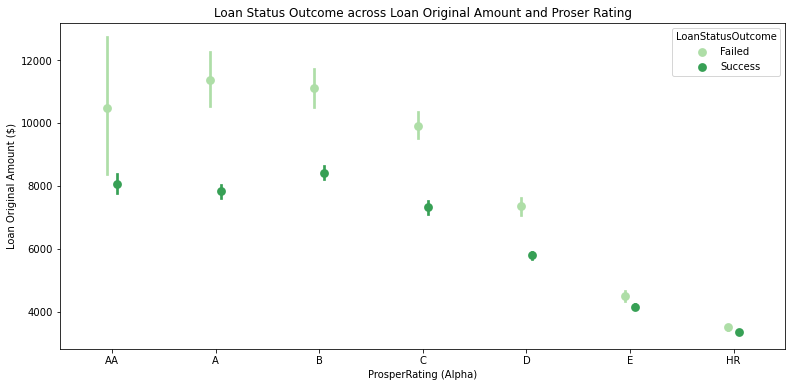

In [22]:
plt.figure(figsize = [13,6])
ax= sns.pointplot(data=new_loan_df, hue='LoanStatusOutcome', x='ProsperRating (Alpha)', y='LoanOriginalAmount', palette='Greens',
                  dodge=0.1, linestyles='')
plt.ylabel('Loan Original Amount ($)')
plt.title('Loan Status Outcome across Loan Original Amount and Proser Rating');